In [2]:
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# --- Paths ---
train_dir = Path("../Combined Dataset/train")
test_dir  = Path("../Combined Dataset/test")

# --- Image transforms ---
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # ensure 1-channel MRI
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# --- Load datasets ---
train_ds = datasets.ImageFolder(root=train_dir, transform=transform)
test_ds  = datasets.ImageFolder(root=test_dir,  transform=transform)

# --- Dataloaders ---
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

# --- Print info ---
print("Classes:", train_ds.classes)
print("Train samples:", len(train_ds))
print("Test samples:", len(test_ds))


Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']
Train samples: 10240
Test samples: 1279


Extracting and flattening data...
Train shape: (10240, 16384), Test shape: (1279, 16384)

Standardizing features...

Applying PCA...
PCA components: 200, Explained variance: 0.824

Performing grid search for Linear SVM (using LinearSVC)...
Fitting 5 folds for each of 5 candidates, totalling 25 fits

Best Linear SVM params: {'C': 0.1}
Best CV macro F1: 0.8487

--- Subsampling for RBF hyperparameter search ---
Using 2000 samples for RBF grid search (original: 10240)
Fitting 3 folds for each of 9 candidates, totalling 27 fits

Best RBF SVM params: {'C': 100, 'gamma': 'scale'}
Best CV macro F1 (on subsample): 0.8818

Retraining best RBF model on full training set...

Best model: RBF SVM

Test Set Performance:
Accuracy: 0.9977
Macro F1: 0.9986

Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       1.00      1.00      1.00       179
 Moderate Impairment       1.00      1.00      1.00        12
       No Impairment       1.00      1.0

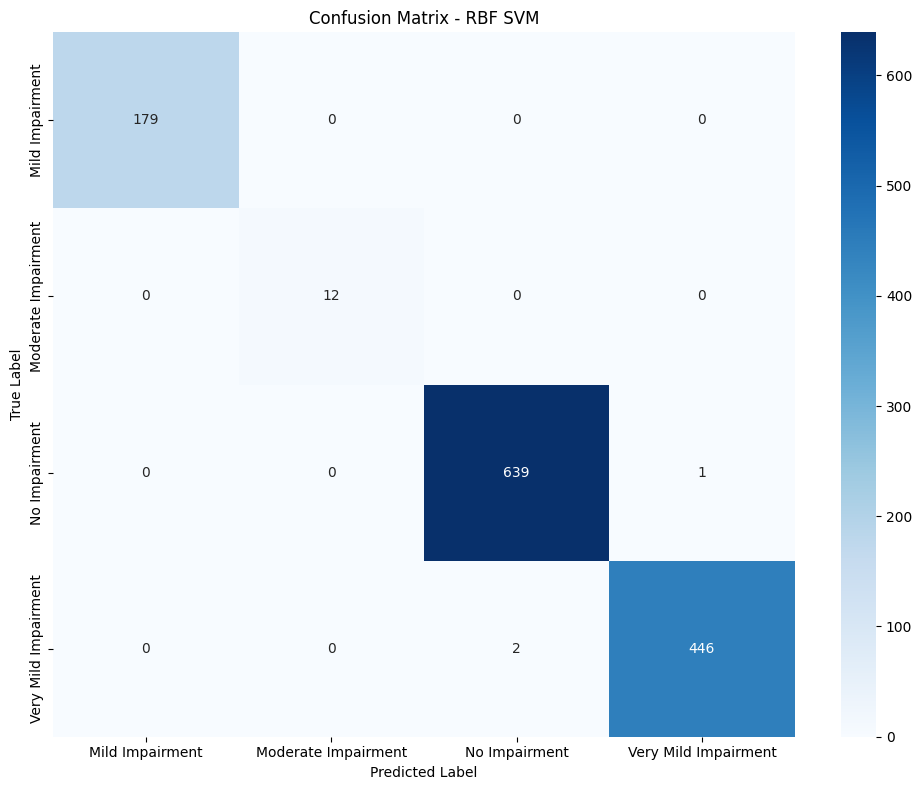

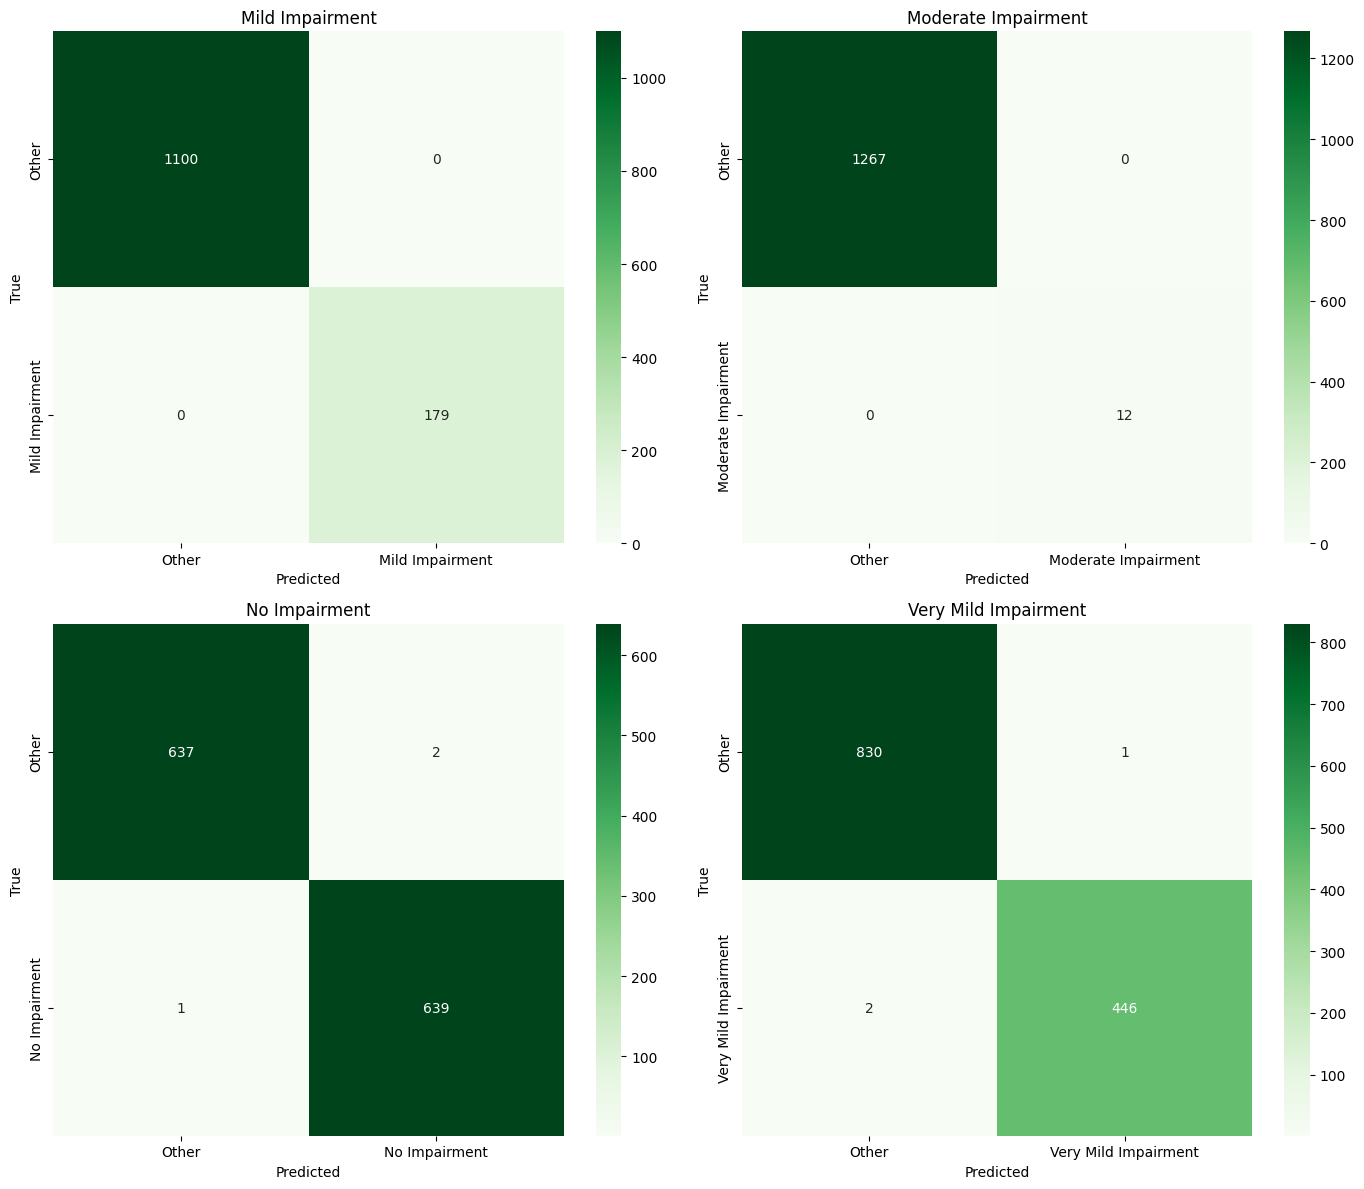

In [3]:
import numpy as np
import torch
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns

# --- Extract images and labels from DataLoaders ---
def extract_data(loader):
    """Convert PyTorch DataLoader to numpy arrays"""
    images_list = []
    labels_list = []
    for imgs, labels in loader:
        images_list.append(imgs.numpy())
        labels_list.append(labels.numpy())
    images = np.concatenate(images_list, axis=0)
    labels = np.concatenate(labels_list, axis=0)
    return images, labels

print("Extracting and flattening data...")
X_train, y_train = extract_data(train_loader)
X_test, y_test = extract_data(test_loader)

# Flatten 128x128 images to vectors
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

print(f"Train shape: {X_train_flat.shape}, Test shape: {X_test_flat.shape}")

# --- Standardization ---
print("\nStandardizing features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

# --- PCA for dimensionality reduction ---
print("\nApplying PCA...")
pca = PCA(n_components=200, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
print(f"PCA components: {pca.n_components_}, Explained variance: {pca.explained_variance_ratio_.sum():.3f}")

# --- OPTIMIZATION 1: LinearSVC for linear kernel (much faster) ---
print("\nPerforming grid search for Linear SVM (using LinearSVC)...")
param_grid_linear = {
    'C': [0.01, 0.1, 1, 10, 100]
}
svm_linear = LinearSVC(max_iter=5000, random_state=42, dual='auto')
grid_linear = GridSearchCV(
    svm_linear, 
    param_grid_linear, 
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)
grid_linear.fit(X_train_pca, y_train)

print(f"\nBest Linear SVM params: {grid_linear.best_params_}")
print(f"Best CV macro F1: {grid_linear.best_score_:.4f}")

# --- OPTIMIZATION 2 & 3: Subsample training data for RBF + smaller grid + fewer folds ---
print("\n--- Subsampling for RBF hyperparameter search ---")
n_subsample = min(2000, len(X_train_pca))  # use max 2000 samples or full set if smaller
X_train_sub, y_train_sub = resample(
    X_train_pca, y_train, 
    n_samples=n_subsample, 
    stratify=y_train, 
    random_state=42
)
print(f"Using {n_subsample} samples for RBF grid search (original: {len(X_train_pca)})")

param_grid_rbf = {
    'C': [1, 10, 100],  # reduced from 4 to 3 values
    'gamma': ['scale', 0.01, 0.1]  # reduced from 5 to 3 values
}
svm_rbf = SVC(kernel='rbf', random_state=42)
grid_rbf = GridSearchCV(
    svm_rbf,
    param_grid_rbf,
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),  # 3-fold instead of 5
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1
)
grid_rbf.fit(X_train_sub, y_train_sub)

print(f"\nBest RBF SVM params: {grid_rbf.best_params_}")
print(f"Best CV macro F1 (on subsample): {grid_rbf.best_score_:.4f}")

# --- Retrain best RBF model on FULL training set ---
print("\nRetraining best RBF model on full training set...")
best_rbf = SVC(kernel='rbf', C=grid_rbf.best_params_['C'], 
               gamma=grid_rbf.best_params_['gamma'], random_state=42)
best_rbf.fit(X_train_pca, y_train)

# --- Select best model and evaluate on test set ---
# Compare linear vs RBF on validation performance
linear_val_f1 = grid_linear.best_score_
rbf_val_f1 = grid_rbf.best_score_

if linear_val_f1 > rbf_val_f1:
    best_model = grid_linear.best_estimator_
    model_name = "Linear SVM"
else:
    best_model = best_rbf
    model_name = "RBF SVM"

print(f"\n{'='*60}")
print(f"Best model: {model_name}")
print(f"{'='*60}")

y_pred = best_model.predict(X_test_pca)

# --- Evaluation metrics ---
accuracy = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average='macro')

print(f"\nTest Set Performance:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Macro F1: {macro_f1:.4f}")
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=train_ds.classes))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=train_ds.classes, 
            yticklabels=train_ds.classes)
plt.title(f'Confusion Matrix - {model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# --- Per-class confusion matrices ---
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, class_name in enumerate(train_ds.classes):
    cm_class = confusion_matrix(y_test == idx, y_pred == idx)
    sns.heatmap(cm_class, annot=True, fmt='d', cmap='Greens', 
                ax=axes[idx], xticklabels=['Other', class_name], 
                yticklabels=['Other', class_name])
    axes[idx].set_title(f'{class_name}')
    axes[idx].set_ylabel('True')
    axes[idx].set_xlabel('Predicted')

plt.tight_layout()
plt.show()